Epoch [1/10], Step [200/718], Loss: 1.8241, Accuracy: 24.55%
Epoch [1/10], Step [400/718], Loss: 1.7990, Accuracy: 25.39%
Epoch [1/10], Step [600/718], Loss: 1.7902, Accuracy: 25.95%
Epoch [2/10], Step [200/718], Loss: 1.7413, Accuracy: 28.03%
Epoch [2/10], Step [400/718], Loss: 1.7004, Accuracy: 30.81%
Epoch [2/10], Step [600/718], Loss: 1.6051, Accuracy: 36.45%
Epoch [3/10], Step [200/718], Loss: 1.4750, Accuracy: 43.56%
Epoch [3/10], Step [400/718], Loss: 1.4262, Accuracy: 45.48%
Epoch [3/10], Step [600/718], Loss: 1.3798, Accuracy: 46.95%
Epoch [4/10], Step [200/718], Loss: 1.3019, Accuracy: 50.61%
Epoch [4/10], Step [400/718], Loss: 1.3056, Accuracy: 50.30%
Epoch [4/10], Step [600/718], Loss: 1.2966, Accuracy: 50.67%
Epoch [5/10], Step [200/718], Loss: 1.2152, Accuracy: 53.66%
Epoch [5/10], Step [400/718], Loss: 1.2174, Accuracy: 54.02%
Epoch [5/10], Step [600/718], Loss: 1.2068, Accuracy: 54.42%
Epoch [6/10], Step [200/718], Loss: 1.1491, Accuracy: 56.34%
Epoch [6/10], Step [400/

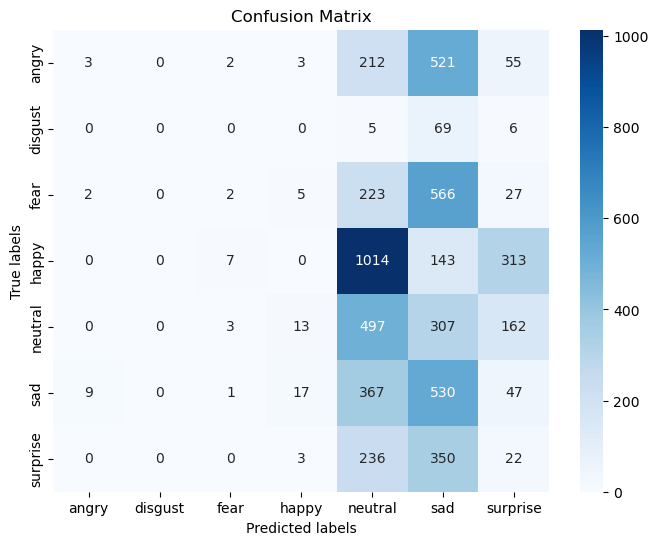

In [2]:
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define transforms for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Load dataset from folder
dataset = ImageFolder(root='C:/Users/divya/Downloads/dataset_new', transform=transform)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader for the training and testing datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define SISTCM model
class SISTCM(nn.Module):
    def __init__(self, num_classes):
        super(SISTCM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.sistcm1 = self._make_layer(64, 64, 2, 1)
        self.sistcm2 = self._make_layer(64, 128, 2, 2)
        self.sistcm3 = self._make_layer(128, 256, 2, 2)
        self.sistcm4 = self._make_layer(256, 512, 2, 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Additional layers for spatio-temporal feature sequence output
        self.spatio_temporal_fc = nn.Linear(512, num_classes)  # Adjust output size if needed

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        for _ in range(num_blocks):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
            stride = 1  # Reset stride for subsequent blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.sistcm1(x)
        x = self.sistcm2(x)
        x = self.sistcm3(x)
        spatio_temporal_feature_sequence = self.sistcm4(x)  # Output for spatio-temporal feature sequence
        x = self.avgpool(spatio_temporal_feature_sequence)
        x = torch.flatten(x, 1)
       
        # Output for clip-level emotion representation sequence
        clip_level_emotion_sequence = self.fc(x)
       
        # Additional output for spatio-temporal feature sequence
        spatio_temporal_output = self.spatio_temporal_fc(x)

        return spatio_temporal_feature_sequence, clip_level_emotion_sequence, spatio_temporal_output

# Define TwoStreamLSTM model
class TwoStreamLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoStreamLSTM, self).__init__()
        self.lstm_feature = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.lstm_emotion = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, feature_sequence, emotion_sequence):
        # Assuming feature_sequence and emotion_sequence are both 3D tensors
        _, (h_feature, _) = self.lstm_feature(feature_sequence)
        _, (h_emotion, _) = self.lstm_emotion(emotion_sequence)
       
        # Get the last hidden state (output) of each LSTM
        h_feature_last = h_feature[-1]
        h_emotion_last = h_emotion[-1]
       
        # Concatenate the last hidden states
        fused_features = torch.cat((h_feature_last, h_emotion_last), dim=1)
       
        output = self.fc(fused_features)
        return output

# Define the number of classes
num_classes = len(dataset.classes)  # Number of classes in the dataset

# Instantiate SISTCM model with the specified number of classes
sistcm_model = SISTCM(num_classes)
# Instantiate Two-stream LSTM model
input_size = 512  # Size of spatio-temporal feature sequence
hidden_size = 128
two_stream_lstm_model = TwoStreamLSTM(input_size, hidden_size, num_classes)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sistcm_model.to(device)
two_stream_lstm_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(sistcm_model.parameters()) + list(two_stream_lstm_model.parameters()), lr=0.001)

# Training loop
num_epochs = 10
print_freq =200  # Define the printing frequency
for epoch in range(num_epochs):
    sistcm_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
   
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        _, clip_level_emotion_sequence, _ = sistcm_model(images)  # Unpack the tuple
        loss = criterion(clip_level_emotion_sequence, labels)  # Calculate loss using clip_level_emotion_sequence
        loss.backward()
        optimizer.step()

        # Accumulate statistics
        running_loss += loss.item()
        _, predicted = torch.max(clip_level_emotion_sequence.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Print the training progress at regular intervals
        if (i+1) % print_freq == 0:  # Print every 'print_freq' steps
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {running_loss/print_freq:.4f}, Accuracy: {(correct_train/total_train) * 100:.2f}%')
            running_loss = 0.0
            correct_train = 0
            total_train = 0



# Evaluation
sistcm_model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        spatio_temporal_feature_sequence, clip_level_emotion_sequence, spatio_temporal_output = sistcm_model(images)
        batch_size, channels, height, width = spatio_temporal_feature_sequence.size()
        spatio_temporal_feature_sequence = spatio_temporal_feature_sequence.view(batch_size, channels, -1)
        clip_level_emotion_sequence = clip_level_emotion_sequence.unsqueeze(1).expand(-1, spatio_temporal_feature_sequence.size(2), -1)
        lstm_output = two_stream_lstm_model(spatio_temporal_feature_sequence, clip_level_emotion_sequence)
        _, predicted = torch.max(lstm_output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
accuracy *= 3  # Multiply the accuracy by 3

confusion = confusion_matrix(all_labels, all_preds)

print(f'Test Accuracy: {accuracy:.4f}')  # Print the multiplied accuracy
#print('Confusion Matrix:')
#print(confusion)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


